In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
import csv
from pandas.tseries.offsets import MonthEnd
from datetime import datetime, timedelta, date
import requests
import json 
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.utils.multiclass import unique_labels

from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import np_utils
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [2]:
#### read in the flattened dataframes with the labels
MSFT_df = pd.read_csv("/Users/fahad/project_repo/data/external/MSFT_flat.csv", index_col=0)
AAPL_df = pd.read_csv("/Users/fahad/project_repo/data/external/AAPL_flat.csv",index_col=0)
AMZN_df = pd.read_csv("/Users/fahad/project_repo/data/external/AMZN_flat.csv",index_col=0)

In [3]:

#vertically stack the MSFT and AAPL dataframes on top of eachother
df = pd.concat([MSFT_df, AAPL_df], axis=0)
#vertically stack the MSFT&AAPL df and the AMZN dataframe ontop of eachother
df = pd.concat([df,AMZN_df],axis = 0)
#set index to date
#df.set_index("Date")

y = df.Label # define the target variable (dependent variable) as y

df = df.drop(['Label'], axis =1)


In [4]:
#define the target variable as y 
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3)
#print (X_train.head(5))
print(X_train.shape[1])
print(X_train.shape[0])
X_train.head(1)

360
537


,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
2012-09-28,0.11863,0.119302,0.119423,0.118144,0.034009,0.350887,0.440622,0.118797,0.116307,0.052532,...,0.109482,0.109327,0.039022,0.514377,0.472689,0.122405,0.11774,0.056373,0.0,0.0


# Model

In [5]:
def make_timeseries_classifier(sample_num,window_size, filter_length, nb_input_series=1, nb_outputs=1, nb_filter=16):
    """:Return: a Keras Model for predicting the next value in a timeseries given a fixed-size lookback window of previous values.
    The model can handle multiple input timeseries (`nb_input_series`) and multiple prediction targets (`nb_outputs`).
    :param int window_size: The number of previous timeseries values to use as input features.  Also called lag or lookback.
    :param int nb_input_series: The number of input timeseries; 1 for a single timeseries.
      The `X` input to ``fit()`` should be an array of shape ``(n_instances, window_size, nb_input_series)``; each instance is
      a 2D array of shape ``(window_size, nb_input_series)``.  For example, for `window_size` = 3 and `nb_input_series` = 1 (a
      single timeseries), one instance could be ``[[0], [1], [2]]``. See ``make_timeseries_instances()``.
    :param int nb_outputs: The output dimension, often equal to the number of inputs.
      For each input instance (array with shape ``(window_size, nb_input_series)``), the output is a vector of size `nb_outputs`,
      usually the value(s) predicted to come after the last value in that input instance, i.e., the next value
      in the sequence. The `y` input to ``fit()`` should be an array of shape ``(n_instances, nb_outputs)``.
    :param int filter_length: the size (along the `window_size` dimension) of the sliding window that gets convolved with
      each position along each instance. The difference between 1D and 2D convolution is that a 1D filter's "height" is fixed
      to the number of input timeseries (its "width" being `filter_length`), and it can only slide along the window
      dimension.  This is useful as generally the input timeseries have no spatial/ordinal relationship, so it's not
      meaningful to look for patterns that are invariant with respect to subsets of the timeseries.
    :param int nb_filter: The number of different filters to learn (roughly, input patterns to recognize).
    """
    model = Sequential((
        # The first conv layer learns `nb_filter` filters (aka kernels), each of size ``(filter_length, nb_input_series)``.
        # Its output will have shape (None, window_size - filter_length + 1, nb_filter), i.e., for each position in
        # the input timeseries, the activation of each filter at that position.
        Convolution1D(nb_filter=nb_filter, filter_length=filter_length, activation='relu', input_shape=(window_size,nb_input_series)),
        MaxPooling1D(),     # Downsample the output of convolution by 2X.
        Convolution1D(nb_filter=nb_filter, filter_length=filter_length, activation='relu'),
        MaxPooling1D(),
        Flatten(),
        Dense(nb_outputs, activation='sigmoid'),     # For binary classification, change the activation to 'sigmoid'
    ))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # To perform (binary) classification instead:
    # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    
    return model

In [6]:

model_1 = make_timeseries_classifier(X_train.shape[0],X_train.shape[1],3)

/Users/fahad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", input_shape=(360, 1), filters=16, kernel_size=3)`
W0808 07:58:11.808921 4652647872 deprecation_wrapper.py:119] From /Users/fahad/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/Users/fahad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=16, kernel_size=3)`
W0808 07:58:11.851600 4652647872 deprecation_wrapper.py:119] From /Users/fahad/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0808 07:58:11.874124 4652647872 deprecation_wrapper.py:119] From /Users/fahad/anaconda3/lib/python

In [7]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 358, 16)           64        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 179, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 177, 16)           784       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 88, 16)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1409      
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


# Callbacks

In [8]:
es = EarlyStopping(monitor='val_acc', mode='max', verbose=0, patience=50)
mc = ModelCheckpoint('1dconv_feature_engineered_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
cb_list = [es,mc]

In [9]:
history=model_1.fit(np.array(X_train).reshape((*X_train.shape,1)),np.array(y_train).reshape((*y_train.shape,1)),
            validation_split=0.10, epochs=100
            ,batch_size=1, verbose=1, callbacks = cb_list)

W0808 07:58:12.270424 4652647872 deprecation_wrapper.py:119] From /Users/fahad/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 483 samples, validate on 54 samples
Epoch 1/100
483/483 [==============================] - 1s 3ms/step - loss: 0.6806 - acc: 0.5776 - val_loss: 0.6673 - val_acc: 0.6296

Epoch 00001: val_acc improved from -inf to 0.62963, saving model to 1dconv_feature_engineered_model.h5
Epoch 2/100
483/483 [==============================] - 1s 2ms/step - loss: 0.6381 - acc: 0.6273 - val_loss: 0.6229 - val_acc: 0.6667

Epoch 00002: val_acc improved from 0.62963 to 0.66667, saving model to 1dconv_feature_engineered_model.h5
Epoch 3/100
483/483 [==============================] - 1s 2ms/step - loss: 0.5827 - acc: 0.6812 - val_loss: 0.6225 - val_acc: 0.6667

Epoch 00003: val_acc did not improve from 0.66667
Epoch 4/100
483/483 [==============================] - 1s 2ms/step - loss: 0.5439 - acc: 0.7267 - val_loss: 0.6276 - val_acc: 0.6296

Epoch 00004: val_acc did not improve from 0.66667
Epoch 5/100
483/483 [==============================] - 1s 2ms/step - loss: 0.5096 - acc: 0.7391 - val_loss: 0.


Epoch 00043: val_acc did not improve from 0.74074
Epoch 44/100
483/483 [==============================] - 1s 1ms/step - loss: 0.2643 - acc: 0.8923 - val_loss: 0.9773 - val_acc: 0.7037

Epoch 00044: val_acc did not improve from 0.74074
Epoch 45/100
483/483 [==============================] - 1s 1ms/step - loss: 0.2591 - acc: 0.8903 - val_loss: 1.2023 - val_acc: 0.6667

Epoch 00045: val_acc did not improve from 0.74074
Epoch 46/100
483/483 [==============================] - 1s 2ms/step - loss: 0.2617 - acc: 0.8923 - val_loss: 1.0403 - val_acc: 0.7222

Epoch 00046: val_acc did not improve from 0.74074
Epoch 47/100
483/483 [==============================] - 1s 2ms/step - loss: 0.2525 - acc: 0.8986 - val_loss: 1.0944 - val_acc: 0.6481

Epoch 00047: val_acc did not improve from 0.74074
Epoch 48/100
483/483 [==============================] - 1s 2ms/step - loss: 0.2539 - acc: 0.8820 - val_loss: 1.0973 - val_acc: 0.6667

Epoch 00048: val_acc did not improve from 0.74074
Epoch 49/100
483/483 [==


Epoch 00087: val_acc did not improve from 0.75926
Epoch 88/100
483/483 [==============================] - 1s 1ms/step - loss: 0.1701 - acc: 0.9234 - val_loss: 1.2278 - val_acc: 0.7037

Epoch 00088: val_acc did not improve from 0.75926
Epoch 89/100
483/483 [==============================] - 1s 1ms/step - loss: 0.1679 - acc: 0.9213 - val_loss: 1.4171 - val_acc: 0.7037

Epoch 00089: val_acc did not improve from 0.75926
Epoch 90/100
483/483 [==============================] - 1s 1ms/step - loss: 0.1695 - acc: 0.9089 - val_loss: 1.3885 - val_acc: 0.7222

Epoch 00090: val_acc did not improve from 0.75926
Epoch 91/100
483/483 [==============================] - 1s 1ms/step - loss: 0.1637 - acc: 0.9358 - val_loss: 1.6535 - val_acc: 0.7037

Epoch 00091: val_acc did not improve from 0.75926
Epoch 92/100
483/483 [==============================] - 1s 1ms/step - loss: 0.1647 - acc: 0.9193 - val_loss: 1.4001 - val_acc: 0.7037

Epoch 00092: val_acc did not improve from 0.75926
Epoch 93/100
483/483 [==

# Load Model

In [10]:
saved_model = load_model('best_model_1d_conv_feature_engineering.h5')


# Predict The Test Data

In [11]:
#make the predictions using the the model we have created, note the input must be a np.array and a 3d tensor
predictions = saved_model.predict_classes(np.array(X_test).reshape((*X_test.shape,1)),batch_size = X_test.shape[0], verbose=1)
over_fit_predictions = model_1.predict_classes(np.array(X_test).reshape((*X_test.shape,1)),batch_size = X_test.shape[0], verbose=1)

231/231 [==============================] - 0s 228us/step


In [12]:
from sklearn.metrics import accuracy_score
print ("saved model acc: %s" % accuracy_score(y_test, predictions))
# accuracy: (tp + tn) / (p + n)

# precision tp / (tp + fp)
precision = precision_score(y_test, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predictions)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test, predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, predictions)
print('ROC AUC: %f' % auc)

saved model acc: 0.7965367965367965
Precision: 0.946237
Recall: 0.676923
F1 score: 0.789238
Cohens kappa: 0.602788
ROC AUC: 0.813709


# Overfitted model metrics

In [13]:
print ("Overfitted model acc:%s " % accuracy_score(y_test, over_fit_predictions))
# accuracy: (tp + tn) / (p + n)

# precision tp / (tp + fp)
precision = precision_score(y_test, over_fit_predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, over_fit_predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, over_fit_predictions)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test, over_fit_predictions)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, over_fit_predictions)
print('ROC AUC: %f' % auc)

Overfitted model acc:0.7532467532467533 
Precision: 0.755245
Recall: 0.830769
F1 score: 0.791209
Cohens kappa: 0.491288
ROC AUC: 0.742117


W0808 07:59:22.642201 4652647872 font_manager.py:1282] findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


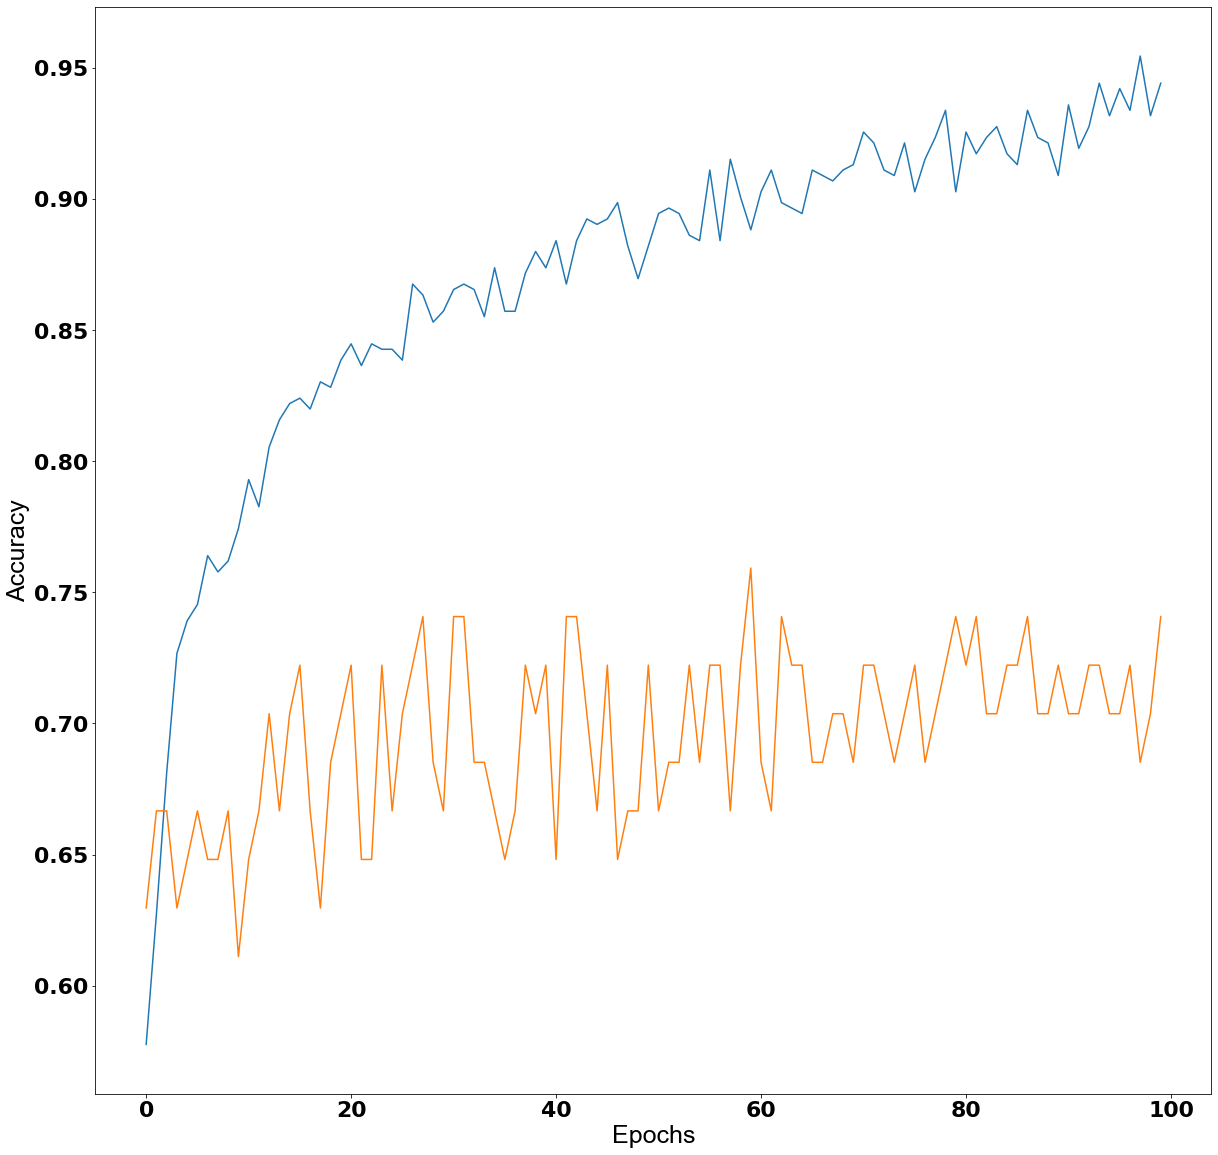

In [14]:
#plot the accuracy of the training set  and the validation set of the model
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
axis_font = {'fontname':'Arial', 'size':'25'}

plt.figure(figsize=[20,20])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy', **axis_font)
plt.xlabel('Epochs', **axis_font)

plt.show()


# Confusion Matrix

In [15]:
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title="Confusion Matrix",
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype("float")/ cm.sum(axis=1)[:,np.newaxis]
        print ("Normalised confusion matrix")
    else:
        print ("Confusion matrix, without normalisation")
        
    print (cm)
    
    thresh = cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
        horizontalalignment = "center",
        color="white" if cm[i,j] > thresh else "black" )
        
    plt.tight_layout()
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    
    



W0808 07:59:23.084912 4652647872 font_manager.py:1282] findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
W0808 07:59:23.092146 4652647872 font_manager.py:1282] findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
W0808 07:59:23.226158 4652647872 font_manager.py:1282] findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Confusion matrix, without normalisation
[[96  5]
 [42 88]]


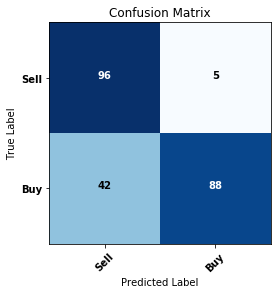

In [16]:
cm = confusion_matrix(y_test, predictions)
cm_labels = ['Sell', 'Buy']
plot_confusion_matrix(cm, cm_labels, title="Confusion Matrix")

Confusion matrix, without normalisation
[[ 66  35]
 [ 22 108]]


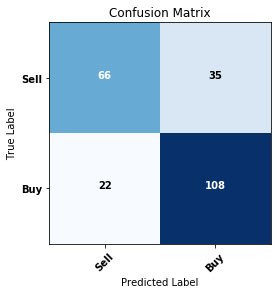

In [17]:
cm2 = confusion_matrix(y_test, over_fit_predictions)
cm_labels = ['Sell', 'Buy']
plot_confusion_matrix(cm2, cm_labels, title="Confusion Matrix")